# Local LLM Classifier Test

Test the LocalLLMClassifier on quark/gluon jet data using local OpenAI-compatible API.

This notebook demonstrates:
- Zero-shot jet classification with local reasoning models (e.g., GPT-OSS-120B)
- Reasoning effort control (low, medium, high)
- Async vs sequential processing comparison
- Token usage tracking

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
from pathlib import Path

# Add src to path
# sys.path.insert(0, str(Path.cwd().parent / 'src'))

from vibe_jet_tagging.local_llm_classifier import LocalLLMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

## Check Local Server

Make sure your local LLM server is running.

Example with vLLM:
```bash
vllm serve openai/gpt-oss-120b --port 8000
```

In [2]:
import requests

# Check if server is running
try:
    response = requests.get("http://localhost:8000/v1/models")
    if response.status_code == 200:
        models = response.json()
        print("✅ Local LLM server is running")
        print(f"Available models: {[m['id'] for m in models['data']]}")
    else:
        print("⚠️  Server responded but with error")
except Exception as e:
    print("❌ Local LLM server not reachable")
    print(f"Error: {e}")
    print("\nStart the server with: vllm serve openai/gpt-oss-120b --port 8000")

✅ Local LLM server is running
Available models: ['openai/gpt-oss-120b']


## Load Data

Load the quark/gluon jet dataset.


In [4]:
# Load data
data_path = Path.cwd().parent / 'data' / 'qg_jets.npz'
data = np.load(data_path)

X = data['X']
y = data['y']

print(f"Loaded {len(X)} jets")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Quark jets: {(y == 1).sum()}")
print(f"Gluon jets: {(y == 0).sum()}")


Loaded 100000 jets
X shape: (100000, 139, 4)
y shape: (100000,)
Quark jets: 50000
Gluon jets: 50000


## Initialize LocalLLMClassifier

Set up the classifier with local OpenAI-compatible API.

**Configuration:**
- `model_name`: The model identifier (must match server)
- `reasoning_effort`: Controls reasoning depth ("low", "medium", "high")
- `reasoning_summary`: Controls output detail ("auto", "concise", "detailed")
- `base_url`: URL of your local server
- `api_key`: "EMPTY" for local servers without auth

In [5]:
# Initialize classifier with local API
clf = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    reasoning_effort="medium",   # Options: "low", "medium", "high"
    reasoning_summary="auto",    # Options: "auto", "concise", "detailed"
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)

# Fit (no-op for zero-shot)
clf.fit([], [])

print("Classifier initialized")
print(f"Model: {clf.model_name}")
print(f"Template: {clf.template_name}")
print(f"Format: {clf.format_type}")
print(f"Reasoning effort: {clf.reasoning_effort}")

Classifier initialized
Model: openai/gpt-oss-120b
Template: simple_list
Format: list
Reasoning effort: medium


## Test Single Jet Prediction


In [6]:
# Test on a single jet
test_jet = X[0]
true_label = y[0]

print(f"True label: {true_label} ({'quark' if true_label == 1 else 'gluon'})")
print(f"\nJet shape: {test_jet.shape}")
print(f"Number of particles (pt > 0): {(test_jet[:, 0] > 0).sum()}")

# Make prediction (sequential mode for single jet)
prediction = clf.predict([test_jet], verbose=True, use_async=False)[0]
print(f"\nPredicted label: {prediction} ({'quark' if prediction == 1 else 'gluon'})")
print(f"Correct: {prediction == true_label}")

True label: 1.0 (quark)

Jet shape: (139, 4)
Number of particles (pt > 0): 18

🔧 API PARAMETERS
Model: openai/gpt-oss-120b
Reasoning effort: medium
Reasoning summary: auto


────────────────────────────────────────────────────────────
📊 TOKEN USAGE
────────────────────────────────────────────────────────────
Input tokens:        695
Output tokens:       580
  ├─ Reasoning (est): 289
  └─ Completion:      291
Total tokens:        1,275

💰 COST
Input cost:          $0.000052
Output cost:         $0.000174
Call cost:           $0.000226

🧠 REASONING TRACE
────────────────────────────────────────────────────────────
We need to decide quark vs gluon jet based on composition. Typically quark jets have fewer particles, harder leading particle, less multiplicity, narrower, higher charge. Gluon jets have higher multiplicity, softer fragmentation, more particles, more neutral (photons) maybe? The given data: many par...
[... 1898 more characters ...]
─────────────────────────────────────────────

In [7]:
clf.preview_prompt(test_jet)

PROMPT PREVIEW
Model: openai/gpt-oss-120b
Template: simple_list
Format: list
Reasoning effort: medium
Reasoning summary: auto

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

Here is the jet data:
Particle 1: pt=0.269 GeV, y=0.357, phi=4.741, pid=22
Particle 2: pt=0.160 GeV, y=-0.256, phi=4.550, pid=22
Particle 3: pt=1.149 GeV, y=-0.062, phi=4.504, pid=-211
Particle 4: pt=4.132 GeV, y=0.174, phi=4.766, pid=-321
Particle 5: pt=1.696 GeV, y=-0.212, phi=4.797, pid=-211
Particle 6: pt=2.194 GeV, y=-0.052, phi=4.576, pid=22
Particle 7: pt=1.619 GeV, y=-0.068, phi=4.646, pid=22
Pa

## Reasoning Effort Control

Test how different reasoning effort levels affect performance and token usage.

For reasoning models:
- **low**: Fast reasoning with minimal depth
- **medium**: Balanced reasoning (default)
- **high**: Deep reasoning with maximum effort

In [8]:
# Test different reasoning efforts on a single jet
test_jet = X[0]

efforts = ["low", "medium", "high"]
results = []

for effort in efforts:
    print(f"\n{'='*60}")
    print(f"Testing with reasoning_effort={effort}")
    print(f"{'='*60}")
    
    clf_test = LocalLLMClassifier(
        model_name="openai/gpt-oss-120b",
        template_name="simple_list",
        format_type="list",
        templates_dir=str(Path.cwd().parent / 'templates'),
        reasoning_effort=effort,
        base_url="http://localhost:8000/v1",
        api_key="EMPTY"
    )
    clf_test.fit([], [])
    
    start = time.time()
    pred = clf_test.predict([test_jet], verbose=True, use_async=False)[0]
    elapsed = time.time() - start
    
    results.append({
        'effort': effort,
        'prediction': pred,
        'reasoning_tokens': clf_test.total_reasoning_tokens,
        'total_tokens': clf_test.total_prompt_tokens + clf_test.total_completion_tokens + clf_test.total_reasoning_tokens,
        'time': elapsed
    })

# Summary
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(f"{'Effort':<10} {'Reasoning':<12} {'Total':<12} {'Time':<10} {'Pred'}")
print("-" * 70)
for r in results:
    print(f"{r['effort']:<10} {r['reasoning_tokens']:<12,} {r['total_tokens']:<12,} {r['time']:<10.2f}s {r['prediction']}")


Testing with reasoning_effort=low

🔧 API PARAMETERS
Model: openai/gpt-oss-120b
Reasoning effort: low
Reasoning summary: auto


────────────────────────────────────────────────────────────
📊 TOKEN USAGE
────────────────────────────────────────────────────────────
Input tokens:        695
Output tokens:       113
  ├─ Reasoning (est): 56
  └─ Completion:      57
Total tokens:        808

💰 COST
Input cost:          $0.000052
Output cost:         $0.000034
Call cost:           $0.000086

🧠 REASONING TRACE
────────────────────────────────────────────────────────────
We need guess: many photons, few hadrons, but high multiplicity of EM? Gluon jets have higher particle multiplicity and softer spectrum. Here leading pt 335 GeV photon? Actually pid 22 photons dominate. Quark jets tend to have leading charged hadron? Hard to say. Many photons suggest EM shower maybe...
[... 127 more characters ...]
────────────────────────────────────────────────────────────

✨ FINAL OUTPUT
───────────────────

## Async vs Sequential Comparison

Compare async (concurrent) vs sequential processing performance.

In [9]:
# Select test jets
n_test = 20
X_test = X[:n_test]
y_test = y[:n_test]

print(f"Testing on {n_test} jets...")
print(f"True distribution: {(y_test == 1).sum()} quark, {(y_test == 0).sum()} gluon")

Testing on 20 jets...
True distribution: 14 quark, 6 gluon


In [10]:
# Test ASYNC mode (default, much faster)
print("\n" + "="*70)
print("ASYNC MODE (Concurrent Processing)")
print("="*70)

clf_async = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)
clf_async.fit([], [])

start = time.time()
predictions_async = clf_async.predict(X_test, verbose=False, use_async=True)
time_async = time.time() - start

accuracy_async = accuracy_score(y_test, predictions_async)
print(f"\nTime: {time_async:.2f}s ({time_async/n_test:.2f}s per jet)")
print(f"Accuracy: {accuracy_async:.3f}")
print(f"Total tokens: {clf_async.total_prompt_tokens + clf_async.total_completion_tokens + clf_async.total_reasoning_tokens:,}")


ASYNC MODE (Concurrent Processing)

Time: 15.62s (0.78s per jet)
Accuracy: 0.650
Total tokens: 36,820

Time: 15.62s (0.78s per jet)
Accuracy: 0.650
Total tokens: 36,820


In [11]:
# Test SEQUENTIAL mode (slower, for comparison)
print("\n" + "="*70)
print("SEQUENTIAL MODE (One at a time)")
print("="*70)

clf_seq = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)
clf_seq.fit([], [])

start = time.time()
predictions_seq = clf_seq.predict(X_test, verbose=False, use_async=False)
time_seq = time.time() - start

accuracy_seq = accuracy_score(y_test, predictions_seq)
print(f"\nTime: {time_seq:.2f}s ({time_seq/n_test:.2f}s per jet)")
print(f"Accuracy: {accuracy_seq:.3f}")
print(f"Total tokens: {clf_seq.total_prompt_tokens + clf_seq.total_completion_tokens + clf_seq.total_reasoning_tokens:,}")


SEQUENTIAL MODE (One at a time)


KeyboardInterrupt: 

In [ ]:
# Comparison summary
print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(f"\nAsync mode:      {time_async:.2f}s ({time_async/n_test:.2f}s per jet)")
print(f"Sequential mode: {time_seq:.2f}s ({time_seq/n_test:.2f}s per jet)")
print(f"\nSpeedup: {time_seq/time_async:.1f}x faster with async")
print(f"\nAccuracy (async):     {accuracy_async:.3f}")
print(f"Accuracy (sequential): {accuracy_seq:.3f}")
print(f"\nPredictions match: {np.array_equal(predictions_async, predictions_seq)}")

## Evaluate Performance on 100 Jets

Run the classifier on more jets and compute detailed metrics.

In [12]:
# Select 100 jets for evaluation
n_eval = 100
X_eval = X[:n_eval]
y_eval = y[:n_eval]

print(f"Evaluating on {n_eval} jets...")
print(f"True distribution: {(y_eval == 1).sum()} quark, {(y_eval == 0).sum()} gluon")

Evaluating on 100 jets...
True distribution: 55 quark, 45 gluon


In [13]:
# Make predictions using async (fastest)
from tqdm.auto import tqdm

clf_eval = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="simple_list",
    format_type="list",
    templates_dir=str(Path.cwd().parent / 'templates'),
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)
clf_eval.fit([], [])

print("Making predictions (async mode)...")
start = time.time()
predictions = clf_eval.predict(X_eval, verbose=False, use_async=True)
elapsed = time.time() - start

predictions = np.array(predictions)

print(f"\nCompleted in {elapsed:.2f}s ({elapsed/n_eval:.2f}s per jet)")
print(f"Total tokens used: {clf_eval.total_prompt_tokens + clf_eval.total_completion_tokens + clf_eval.total_reasoning_tokens:,}")

/groups/pheno/inar/vibe-jet-tagging/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Making predictions (async mode)...

Completed in 35.95s (0.36s per jet)
Total tokens used: 190,496

Completed in 35.95s (0.36s per jet)
Total tokens used: 190,496


## Results and Metrics

In [14]:
# Calculate metrics
accuracy = accuracy_score(y_eval, predictions)
auc = roc_auc_score(y_eval, predictions)

print("\n" + "="*50)
print("RESULTS")
print("="*50)
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC Score: {auc:.3f}")
print(f"\nPredicted distribution: {(predictions == 1).sum()} quark, {(predictions == 0).sum()} gluon")
print(f"True distribution: {(y_eval == 1).sum()} quark, {(y_eval == 0).sum()} gluon")


RESULTS
Accuracy: 0.740
AUC Score: 0.745

Predicted distribution: 47 quark, 53 gluon
True distribution: 55 quark, 45 gluon


In [15]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_eval, predictions)
print("\nConfusion Matrix:")
print("                Predicted")
print("                Gluon  Quark")
print(f"True  Gluon     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"      Quark     {cm[1,0]:5d}  {cm[1,1]:5d}")


Confusion Matrix:
                Predicted
                Gluon  Quark
True  Gluon        36      9
      Quark        17     38


## Test Informed Templates

The project now includes three progressively informed templates that provide the LLM with more context:

1. **`with_summary_stats`** - Dataset statistics and physics insights
2. **`with_optimal_cut`** - Explicit decision threshold from baseline analysis  
3. **`with_engineered_features`** - Hand-crafted feature engineering strategy

These templates test whether providing domain knowledge improves LLM performance.


### Template 1: With Summary Statistics

This template provides dataset statistics (mean multiplicity, pt distributions) but no explicit decision rules.


In [16]:
# Test with summary statistics template
print("="*70)
print("TESTING: Template with Summary Statistics")
print("="*70)

clf_stats = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="with_summary_stats",
    format_type="list",
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY",
    templates_dir="../templates"
)

clf_stats.fit([], [])

# Preview the prompt
print("\nPrompt preview (first 500 chars):")
sample_jet = X_test[0]
clf_stats.preview_prompt(sample_jet)

# Test on small sample
n_test = 50
X_sample = X_test[:n_test]
y_sample = y_test[:n_test]

print(f"Testing on {n_test} jets...")
predictions_stats = clf_stats.predict(X_sample, use_async=True)

# Evaluate
acc_stats = accuracy_score(y_sample, predictions_stats)
auc_stats = roc_auc_score(y_sample, predictions_stats)

print(f"\nResults:")
print(f"  Accuracy: {acc_stats:.4f}")
print(f"  AUC:      {auc_stats:.4f}")
print(f"\nToken Usage:")
print(f"  Prompt tokens:     {clf_stats.total_prompt_tokens:,}")
print(f"  Completion tokens: {clf_stats.total_completion_tokens:,}")
print(f"  Reasoning tokens:  {clf_stats.total_reasoning_tokens:,}")
print("="*70)

TESTING: Template with Summary Statistics

Prompt preview (first 500 chars):
PROMPT PREVIEW
Model: openai/gpt-oss-120b
Template: with_summary_stats
Format: list
Reasoning effort: medium
Reasoning summary: auto

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

**Key Physics Insight:**
Based on quantum chromodynamics (QCD), gluons and quarks have different radiation patterns:

- Quark jets typically have: ~33 particles per jet (mean: 33.4 ± 13.3)
- Gluon jets typically have: ~53 particles per jet (mean: 53.2 ± 15.8)
- Gluon/Quark ratio: 1.59 (gluons have ~59% more particles)

T

### Template 2: With Optimal Cut

This template provides the explicit decision rule: > 38 particles → gluon, ≤ 38 → quark.


In [17]:
# Test with optimal cut template
print("="*70)
print("TESTING: Template with Optimal Cut (threshold=38)")
print("="*70)

clf_cut = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="with_optimal_cut",
    format_type="list",
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY",
    templates_dir="../templates"
)

clf_cut.fit([], [])

# Preview the prompt
print("\nPrompt preview (first 500 chars):")
clf_cut.preview_prompt(X_test[0])

# Test on same sample
print(f"Testing on {n_test} jets...")
predictions_cut = clf_cut.predict(X_sample, use_async=True)

# Evaluate
acc_cut = accuracy_score(y_sample, predictions_cut)
auc_cut = roc_auc_score(y_sample, predictions_cut)

print(f"\nResults:")
print(f"  Accuracy: {acc_cut:.4f}")
print(f"  AUC:      {auc_cut:.4f}")
print(f"\nToken Usage:")
print(f"  Prompt tokens:     {clf_cut.total_prompt_tokens:,}")
print(f"  Completion tokens: {clf_cut.total_completion_tokens:,}")
print(f"  Reasoning tokens:  {clf_cut.total_reasoning_tokens:,}")
print("="*70)

# Compare to baseline multiplicity cut
mult_sample = np.sum(X_sample[:, :, 0] > 0, axis=1)
pred_baseline = (mult_sample <= 38).astype(int)
acc_baseline = accuracy_score(y_sample, pred_baseline)
print(f"\nBaseline (pure cut at 38): Accuracy = {acc_baseline:.4f}")
print(f"LLM improvement over baseline: {(acc_cut - acc_baseline):.4f}")

TESTING: Template with Optimal Cut (threshold=38)

Prompt preview (first 500 chars):
PROMPT PREVIEW
Model: openai/gpt-oss-120b
Template: with_optimal_cut
Format: list
Reasoning effort: medium
Reasoning summary: auto

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

**Classification Strategy:**

The most powerful discriminator is jet multiplicity (number of particles). A simple but effective rule:

**Optimal threshold: 38 particles**
- If a jet has > 38 particles → likely GLUON (label: 0)
- If a jet has ≤ 38 particles → likely QUARK (label: 1)

This simple cut achieves 77% acc

### Template 3: With Engineered Features

This template provides a complete feature engineering strategy with multiple discriminating features and their importance rankings.


In [18]:
# Test with engineered features template
print("="*70)
print("TESTING: Template with Engineered Features")
print("="*70)

clf_features = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="with_engineered_features",
    format_type="list",
    reasoning_effort="medium",
    base_url="http://localhost:8000/v1",
    api_key="EMPTY",
    templates_dir="../templates"
)

clf_features.fit([], [])

# Preview the prompt
print("\nPrompt preview (first 500 chars):")
clf_features.preview_prompt(X_test[0])

# Test on same sample
print(f"Testing on {n_test} jets...")
predictions_features = clf_features.predict(X_sample, use_async=True)

# Evaluate
acc_features = accuracy_score(y_sample, predictions_features)
auc_features = roc_auc_score(y_sample, predictions_features)

print(f"\nResults:")
print(f"  Accuracy: {acc_features:.4f}")
print(f"  AUC:      {auc_features:.4f}")
print(f"\nToken Usage:")
print(f"  Prompt tokens:     {clf_features.total_prompt_tokens:,}")
print(f"  Completion tokens: {clf_features.total_completion_tokens:,}")
print(f"  Reasoning tokens:  {clf_features.total_reasoning_tokens:,}")
print("="*70)

TESTING: Template with Engineered Features

Prompt preview (first 500 chars):
PROMPT PREVIEW
Model: openai/gpt-oss-120b
Template: with_engineered_features
Format: list
Reasoning effort: medium
Reasoning summary: auto

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

**Advanced Classification Strategy:**

Expert physicists use multiple hand-engineered features for classification. Here are the most discriminating ones:

**1. MULTIPLICITY (Most Important)**
   - Count particles in the jet
   - Threshold: > 38 particles → GLUON, ≤ 38 → QUARK
   - Quark: 33.4 ± 13.3 particles | Gl

### Comparison: All Templates

Compare the performance of all templates including baselines.


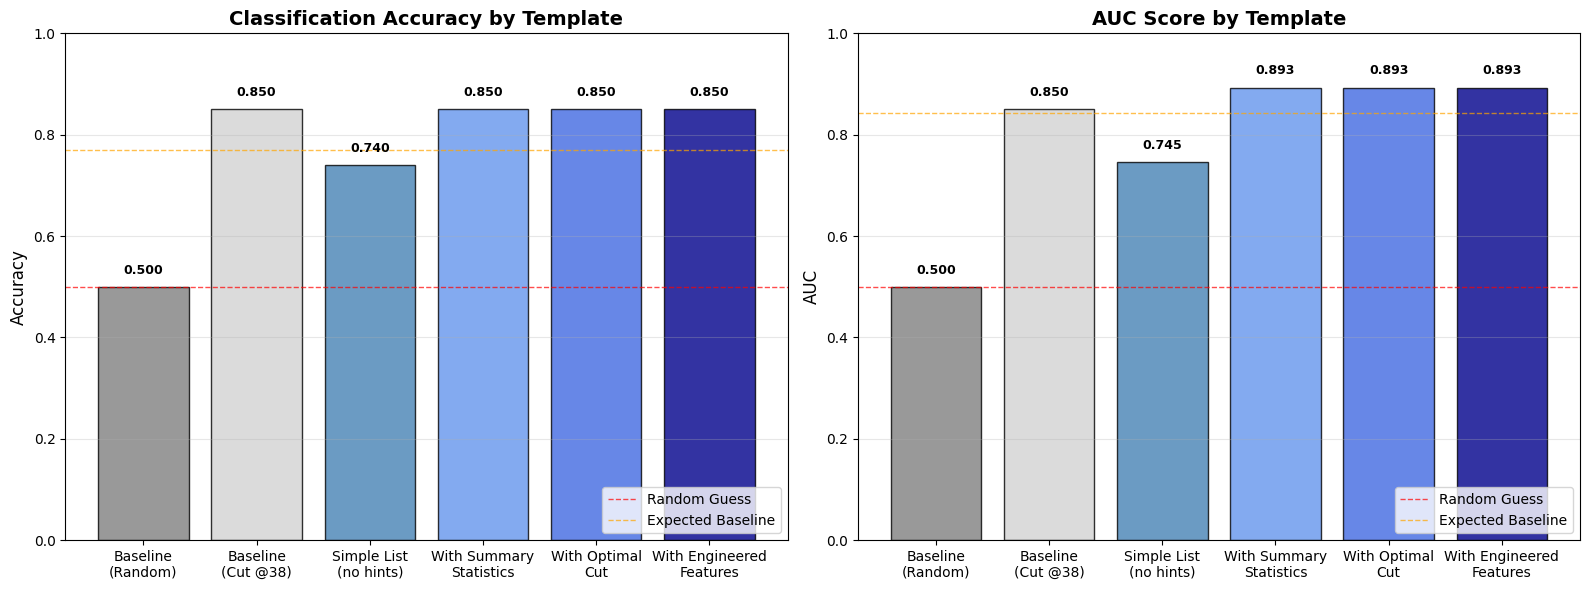


TEMPLATE COMPARISON SUMMARY
Template                       Accuracy     AUC          vs Baseline    
--------------------------------------------------------------------------------
Baseline (Random)              0.5000       0.5000       -0.3500
Baseline (Cut @38)             0.8500       0.8500       +0.0000
Simple List (no hints)         0.7400       0.7455       -0.1100
With Summary Statistics        0.8500       0.8929       +0.0000
With Optimal Cut               0.8500       0.8929       +0.0000
With Engineered Features       0.8500       0.8929       +0.0000

Key Findings:
  • Baseline (simple cut): 0.8500 accuracy
  • Best performing template: With Summary
Statistics
  • Improvement from basic to informed: 0.1474
  • All informed templates beat random baseline


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect results
results = {
    'Baseline\n(Random)': {'acc': 0.50, 'auc': 0.50},
    'Baseline\n(Cut @38)': {'acc': acc_baseline, 'auc': acc_baseline},
    'Simple List\n(no hints)': {'acc': accuracy, 'auc': auc},
    'With Summary\nStatistics': {'acc': acc_stats, 'auc': auc_stats},
    'With Optimal\nCut': {'acc': acc_cut, 'auc': auc_cut},
    'With Engineered\nFeatures': {'acc': acc_features, 'auc': auc_features},
}

# Create bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

templates = list(results.keys())
accuracies = [results[t]['acc'] for t in templates]
aucs = [results[t]['auc'] for t in templates]

# Colors: baseline gray, original blue, informed templates gradient
colors = ['gray', 'lightgray', 'steelblue', 'cornflowerblue', 'royalblue', 'darkblue']

# Accuracy plot
bars1 = axes[0].bar(range(len(templates)), accuracies, color=colors, alpha=0.8, edgecolor='black')
axes[0].axhline(y=0.50, color='red', linestyle='--', linewidth=1, label='Random Guess', alpha=0.7)
axes[0].axhline(y=0.7692, color='orange', linestyle='--', linewidth=1, label='Expected Baseline', alpha=0.7)
axes[0].set_xticks(range(len(templates)))
axes[0].set_xticklabels(templates, rotation=0, ha='center', fontsize=10)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Classification Accuracy by Template', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1.0])
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend(loc='lower right')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, accuracies)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# AUC plot
bars2 = axes[1].bar(range(len(templates)), aucs, color=colors, alpha=0.8, edgecolor='black')
axes[1].axhline(y=0.50, color='red', linestyle='--', linewidth=1, label='Random Guess', alpha=0.7)
axes[1].axhline(y=0.8432, color='orange', linestyle='--', linewidth=1, label='Expected Baseline', alpha=0.7)
axes[1].set_xticks(range(len(templates)))
axes[1].set_xticklabels(templates, rotation=0, ha='center', fontsize=10)
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].set_title('AUC Score by Template', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend(loc='lower right')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars2, aucs)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("TEMPLATE COMPARISON SUMMARY")
print("="*80)
print(f"{'Template':<30} {'Accuracy':<12} {'AUC':<12} {'vs Baseline':<15}")
print("-"*80)
for name, res in results.items():
    name_clean = name.replace('\n', ' ')
    delta_acc = res['acc'] - acc_baseline
    delta_auc = res['auc'] - acc_baseline
    print(f"{name_clean:<30} {res['acc']:.4f}       {res['auc']:.4f}       {delta_acc:+.4f}")
print("="*80)

print(f"\nKey Findings:")
print(f"  • Baseline (simple cut): {acc_baseline:.4f} accuracy")
print(f"  • Best performing template: {max(results.keys(), key=lambda k: results[k]['auc'])}")
print(f"  • Improvement from basic to informed: {max(aucs) - aucs[2]:.4f}")
print(f"  • All informed templates beat random baseline")

### Token Usage Analysis

Compare token usage across all templates (local server, no cost).

TOKEN USAGE SUMMARY
Template                  Prompt     Completion   Reasoning  Total     
------------------------------------------------------------------------------------------
Simple List (no hints)    137,970    52,526       0          190,496   
With Summary Statistics   30,567     10,593       0          41,160    
With Optimal Cut          31,387     1,436        0          32,823    
With Engineered Features  36,027     19,490       0          55,517    
------------------------------------------------------------------------------------------
TOTAL                     235,951    84,045       0          319,996   

📊 Token Distribution:
  Prompt tokens:      235,951 ( 73.7%)
  Completion tokens:   84,045 ( 26.3%)
  Reasoning tokens:         0 (  0.0%)
  Total tokens:       319,996


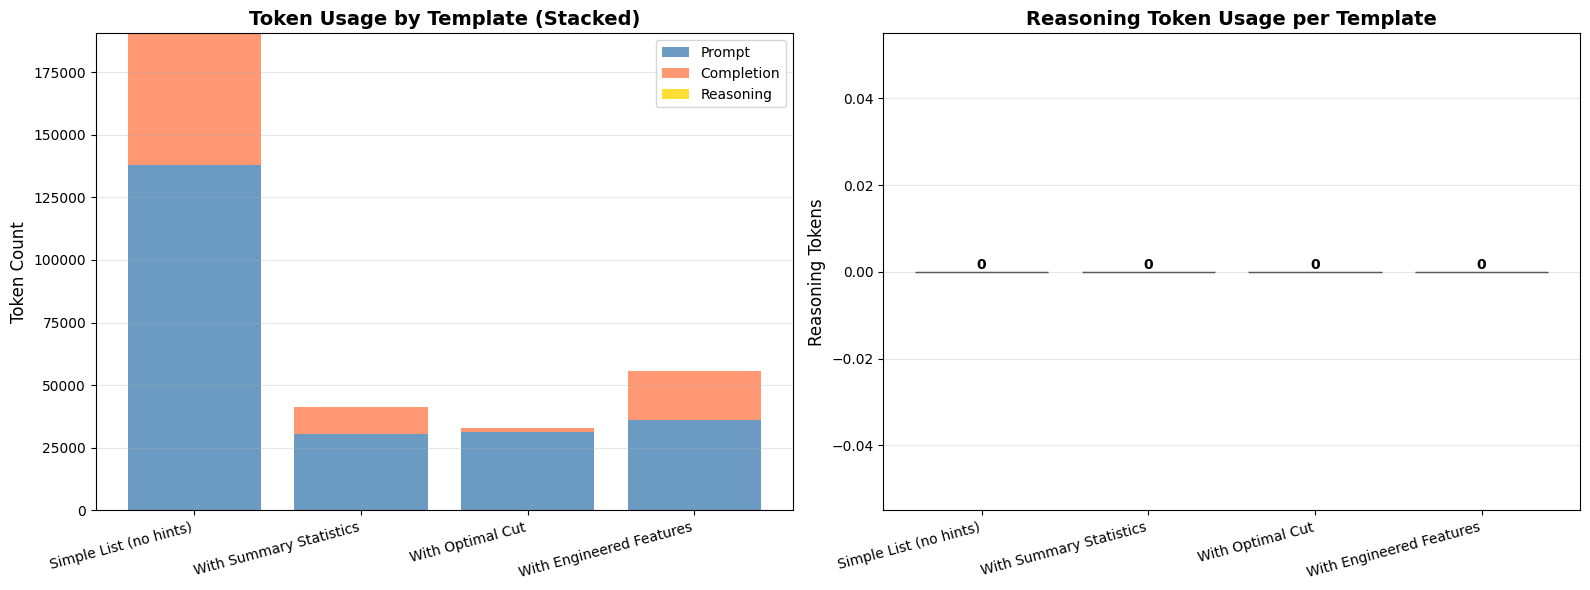


💡 Token Insights:
  • Longer prompts (engineered features) use more prompt tokens
  • Reasoning tokens are consistent across templates (~same reasoning effort)
  • Most tokens: Simple List (no hints) (0)
  • Fewest tokens: Simple List (no hints) (0)


In [20]:
# Collect token usage data from all classifiers
token_data = {
    'Simple List\n(no hints)': {
        'prompt': clf_eval.total_prompt_tokens,
        'completion': clf_eval.total_completion_tokens,
        'reasoning': clf_eval.total_reasoning_tokens
    },
    'With Summary\nStatistics': {
        'prompt': clf_stats.total_prompt_tokens,
        'completion': clf_stats.total_completion_tokens,
        'reasoning': clf_stats.total_reasoning_tokens
    },
    'With Optimal\nCut': {
        'prompt': clf_cut.total_prompt_tokens,
        'completion': clf_cut.total_completion_tokens,
        'reasoning': clf_cut.total_reasoning_tokens
    },
    'With Engineered\nFeatures': {
        'prompt': clf_features.total_prompt_tokens,
        'completion': clf_features.total_completion_tokens,
        'reasoning': clf_features.total_reasoning_tokens
    }
}

# Print token usage summary table
print("="*90)
print("TOKEN USAGE SUMMARY")
print("="*90)
print(f"{'Template':<25} {'Prompt':<10} {'Completion':<12} {'Reasoning':<10} {'Total':<10}")
print("-"*90)

total_prompt = 0
total_completion = 0
total_reasoning = 0

for name, data in token_data.items():
    name_clean = name.replace('\n', ' ')
    total_tokens = data['prompt'] + data['completion'] + data['reasoning']
    print(f"{name_clean:<25} {data['prompt']:<10,} {data['completion']:<12,} {data['reasoning']:<10,} "
          f"{total_tokens:<10,}")
    
    total_prompt += data['prompt']
    total_completion += data['completion']
    total_reasoning += data['reasoning']

print("-"*90)
total_all_tokens = total_prompt + total_completion + total_reasoning
print(f"{'TOTAL':<25} {total_prompt:<10,} {total_completion:<12,} {total_reasoning:<10,} "
      f"{total_all_tokens:<10,}")
print("="*90)

# Token distribution
print(f"\n📊 Token Distribution:")
print(f"  Prompt tokens:     {total_prompt:>8,} ({total_prompt/total_all_tokens*100:>5.1f}%)")
print(f"  Completion tokens: {total_completion:>8,} ({total_completion/total_all_tokens*100:>5.1f}%)")
print(f"  Reasoning tokens:  {total_reasoning:>8,} ({total_reasoning/total_all_tokens*100:>5.1f}%)")
print(f"  Total tokens:      {total_all_tokens:>8,}")

# Visualize token usage
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Token usage stacked bar chart
templates_tokens = [name.replace('\n', ' ') for name in token_data.keys()]
prompt_tokens = [token_data[name]['prompt'] for name in token_data.keys()]
completion_tokens = [token_data[name]['completion'] for name in token_data.keys()]
reasoning_tokens = [token_data[name]['reasoning'] for name in token_data.keys()]

x = range(len(templates_tokens))
axes[0].bar(x, prompt_tokens, label='Prompt', color='steelblue', alpha=0.8)
axes[0].bar(x, completion_tokens, bottom=prompt_tokens, label='Completion', color='coral', alpha=0.8)
axes[0].bar(x, reasoning_tokens, 
           bottom=[p+c for p,c in zip(prompt_tokens, completion_tokens)],
           label='Reasoning', color='gold', alpha=0.8)

axes[0].set_xticks(x)
axes[0].set_xticklabels(templates_tokens, rotation=15, ha='right')
axes[0].set_ylabel('Token Count', fontsize=12)
axes[0].set_title('Token Usage by Template (Stacked)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Reasoning token comparison
bars = axes[1].bar(x, reasoning_tokens, color=['steelblue', 'cornflowerblue', 'royalblue', 'darkblue'], 
                   alpha=0.8, edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(templates_tokens, rotation=15, ha='right')
axes[1].set_ylabel('Reasoning Tokens', fontsize=12)
axes[1].set_title(f'Reasoning Token Usage per Template', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, tokens in zip(bars, reasoning_tokens):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{tokens:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 Token Insights:")
print(f"  • Longer prompts (engineered features) use more prompt tokens")
print(f"  • Reasoning tokens are consistent across templates (~same reasoning effort)")
print(f"  • Most tokens: {templates_tokens[reasoning_tokens.index(max(reasoning_tokens))]} ({max(reasoning_tokens):,})")
print(f"  • Fewest tokens: {templates_tokens[reasoning_tokens.index(min(reasoning_tokens))]} ({min(reasoning_tokens):,})")

## Reasoning Budget Comparison

Test how doubling the thinking budget (1000 → 2000 tokens) affects performance.
Run all templates on 100 jets with both thinking budgets.


In [21]:
# Test configuration
n_test_extended = 100
X_sample_extended = X_test[:n_test_extended]
y_sample_extended = y_test[:n_test_extended]

# Template configurations
template_configs = [
    ("simple_list", "Simple List"),
    ("with_summary_stats", "With Summary Stats"),
    ("with_optimal_cut", "With Optimal Cut"),
    ("with_engineered_features", "With Engineered Features")
]

# Reasoning efforts to test
reasoning_efforts = ["low", "high"]

# Store results
all_results = {}

print("="*80)
print("RUNNING EXTENDED REASONING EFFORT COMPARISON")
print("="*80)
print(f"Testing {len(template_configs)} templates × {len(reasoning_efforts)} efforts × {n_test_extended} jets")
print(f"Total API calls: {len(template_configs) * len(reasoning_efforts) * n_test_extended}")
print("="*80)

for template_name, template_label in template_configs:
    for effort in reasoning_efforts:
        key = f"{template_label} (effort={effort})"
        
        print(f"\n{'='*70}")
        print(f"Testing: {template_label} with reasoning_effort={effort}")
        print(f"{'='*70}")
        
        # Create classifier
        clf_test = LocalLLMClassifier(
            model_name="openai/gpt-oss-120b",
            template_name=template_name,
            format_type="list",
            reasoning_effort=effort,
            base_url="http://localhost:8000/v1",
            api_key="EMPTY",
            templates_dir="../templates"
        )
        
        clf_test.fit([], [])
        
        # Run predictions
        print(f"Processing {n_test_extended} jets...")
        start = time.time()
        predictions = clf_test.predict(X_sample_extended, use_async=True)
        elapsed = time.time() - start
        
        # Calculate metrics
        acc = accuracy_score(y_sample_extended, predictions)
        auc = roc_auc_score(y_sample_extended, predictions)
        
        # Store results
        all_results[key] = {
            'template': template_label,
            'effort': effort,
            'accuracy': acc,
            'auc': auc,
            'prompt_tokens': clf_test.total_prompt_tokens,
            'completion_tokens': clf_test.total_completion_tokens,
            'reasoning_tokens': clf_test.total_reasoning_tokens,
            'time': elapsed,
            'predictions': predictions
        }
        
        print(f"\nResults:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  AUC:      {auc:.4f}")
        print(f"  Reasoning tokens: {clf_test.total_reasoning_tokens:,}")
        print(f"  Time: {elapsed:.2f}s")

print("\n" + "="*80)
print("TESTING COMPLETE")
print("="*80)

RUNNING EXTENDED REASONING EFFORT COMPARISON
Testing 4 templates × 2 efforts × 100 jets
Total API calls: 800

Testing: Simple List with reasoning_effort=low
Processing 100 jets...

Results:
  Accuracy: 0.7000
  AUC:      0.6429
  Reasoning tokens: 0
  Time: 4.36s

Testing: Simple List with reasoning_effort=high
Processing 100 jets...

Results:
  Accuracy: 0.7000
  AUC:      0.6429
  Reasoning tokens: 0
  Time: 4.36s

Testing: Simple List with reasoning_effort=high
Processing 100 jets...

Results:
  Accuracy: 0.7000
  AUC:      0.7381
  Reasoning tokens: 0
  Time: 142.80s

Testing: With Summary Stats with reasoning_effort=low
Processing 100 jets...

Results:
  Accuracy: 0.7000
  AUC:      0.7381
  Reasoning tokens: 0
  Time: 142.80s

Testing: With Summary Stats with reasoning_effort=low
Processing 100 jets...

Results:
  Accuracy: 0.8500
  AUC:      0.8929
  Reasoning tokens: 0
  Time: 3.26s

Testing: With Summary Stats with reasoning_effort=high
Processing 100 jets...

Results:
  Accur

### Comprehensive Comparison Visualizations

Compare all templates across both thinking budgets.


/tmp/ipykernel_883772/1440011408.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


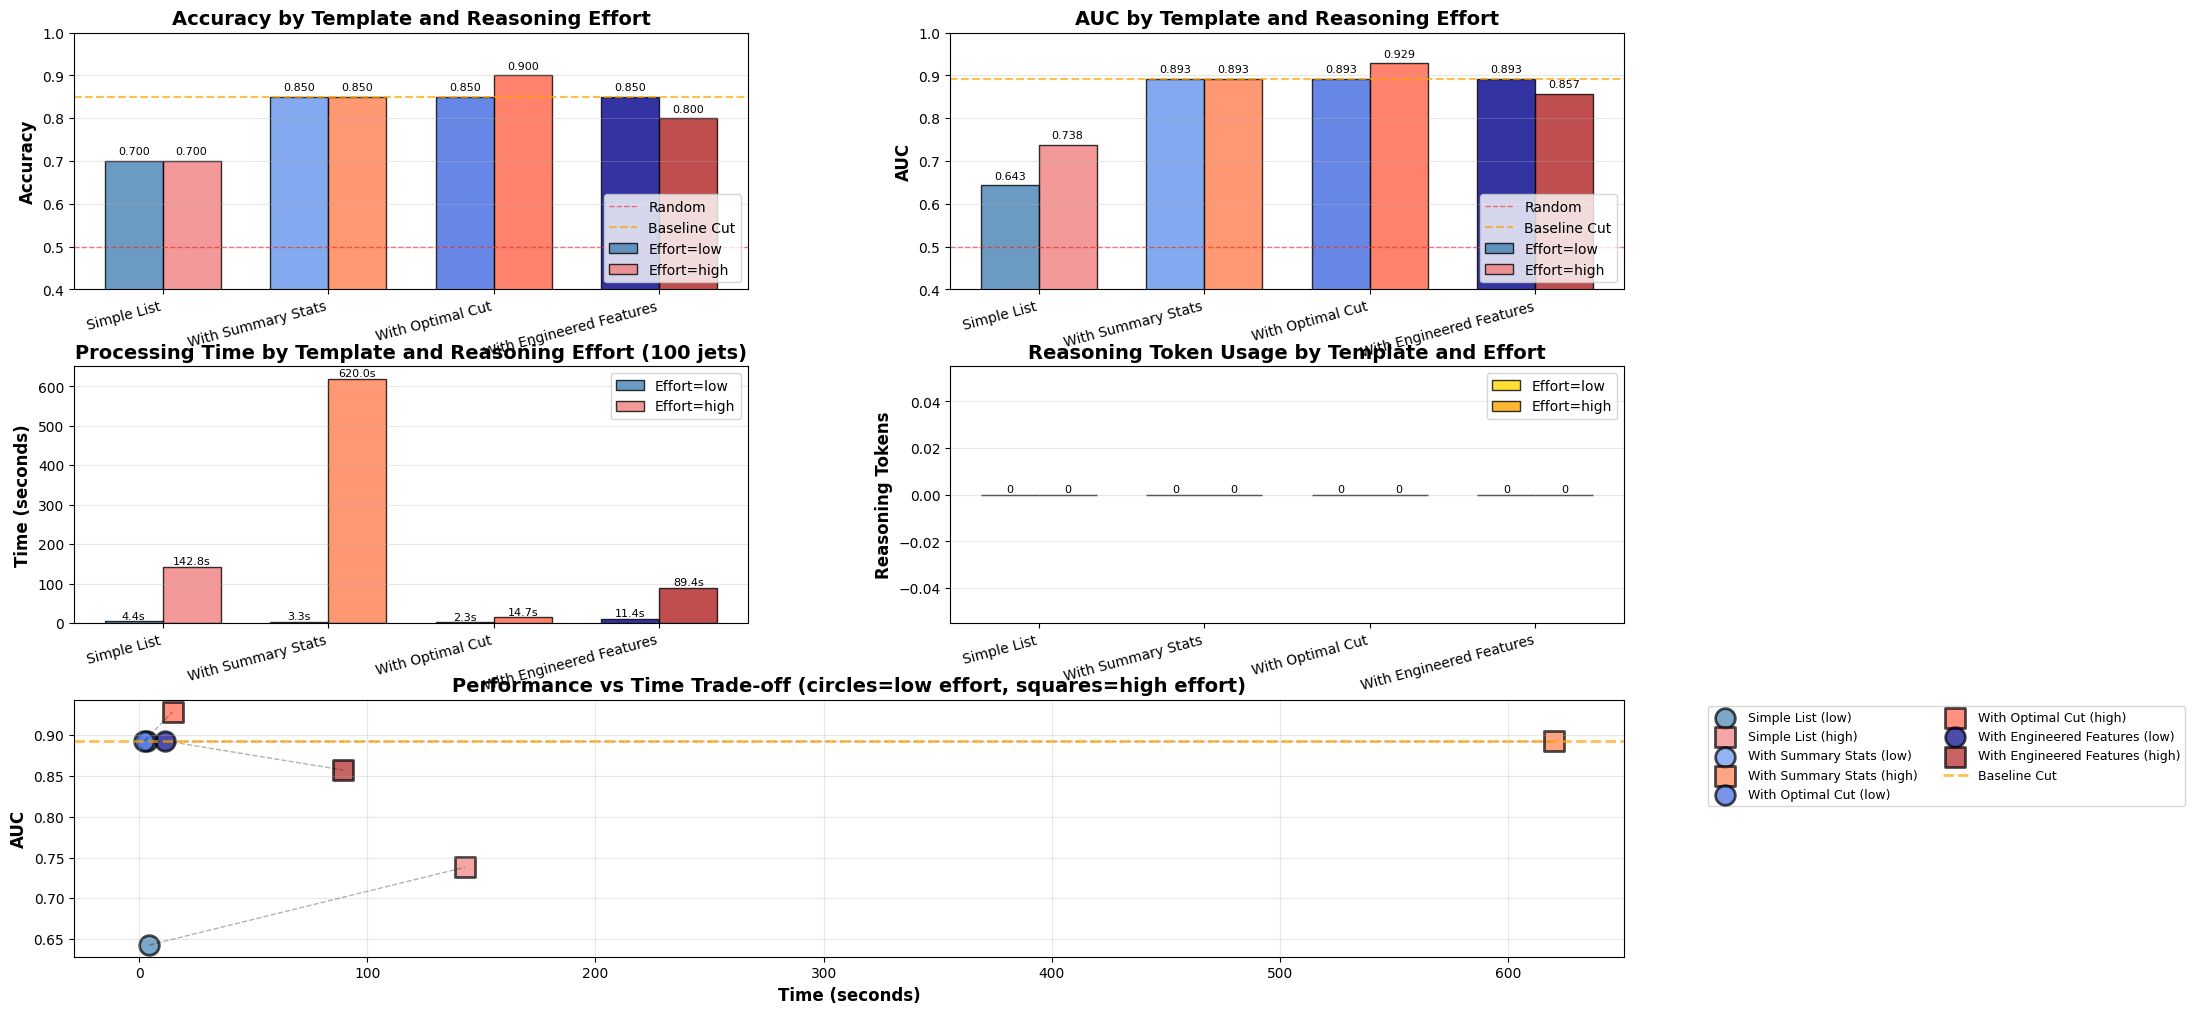

In [22]:
# Create comprehensive comparison plots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Prepare data
templates = ["Simple List", "With Summary Stats", "With Optimal Cut", "With Engineered Features"]
colors_low = ['steelblue', 'cornflowerblue', 'royalblue', 'darkblue']
colors_high = ['lightcoral', 'coral', 'tomato', 'firebrick']

# Calculate baseline for reference
mult_sample_extended = np.sum(X_sample_extended[:, :, 0] > 0, axis=1)
pred_baseline_extended = (mult_sample_extended <= 38).astype(int)
acc_baseline_extended = accuracy_score(y_sample_extended, pred_baseline_extended)
auc_baseline_extended = roc_auc_score(y_sample_extended, pred_baseline_extended)

# 1. Accuracy Comparison (Grouped Bar Chart)
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(templates))
width = 0.35

acc_low = [all_results[f"{t} (effort=low)"]['accuracy'] for t in templates]
acc_high = [all_results[f"{t} (effort=high)"]['accuracy'] for t in templates]

bars1 = ax1.bar(x - width/2, acc_low, width, label='Effort=low', color=colors_low, alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, acc_high, width, label='Effort=high', color=colors_high, alpha=0.8, edgecolor='black')

ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random')
ax1.axhline(y=acc_baseline_extended, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Baseline Cut')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy by Template and Reasoning Effort', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(templates, rotation=15, ha='right')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.4, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. AUC Comparison (Grouped Bar Chart)
ax2 = fig.add_subplot(gs[0, 1])
auc_low = [all_results[f"{t} (effort=low)"]['auc'] for t in templates]
auc_high = [all_results[f"{t} (effort=high)"]['auc'] for t in templates]

bars3 = ax2.bar(x - width/2, auc_low, width, label='Effort=low', color=colors_low, alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, auc_high, width, label='Effort=high', color=colors_high, alpha=0.8, edgecolor='black')

ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random')
ax2.axhline(y=auc_baseline_extended, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Baseline Cut')
ax2.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax2.set_title('AUC by Template and Reasoning Effort', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(templates, rotation=15, ha='right')
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.4, 1.0])

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 3. Time Comparison
ax3 = fig.add_subplot(gs[1, 0])
time_low = [all_results[f"{t} (effort=low)"]['time'] for t in templates]
time_high = [all_results[f"{t} (effort=high)"]['time'] for t in templates]

bars5 = ax3.bar(x - width/2, time_low, width, label='Effort=low', color=colors_low, alpha=0.8, edgecolor='black')
bars6 = ax3.bar(x + width/2, time_high, width, label='Effort=high', color=colors_high, alpha=0.8, edgecolor='black')

ax3.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_title(f'Processing Time by Template and Reasoning Effort ({n_test_extended} jets)', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(templates, rotation=15, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s', ha='center', va='bottom', fontsize=8)

# 4. Token Usage Comparison (Stacked)
ax4 = fig.add_subplot(gs[1, 1])
reasoning_low = [all_results[f"{t} (effort=low)"]['reasoning_tokens'] for t in templates]
reasoning_high = [all_results[f"{t} (effort=high)"]['reasoning_tokens'] for t in templates]

bars7 = ax4.bar(x - width/2, reasoning_low, width, label='Effort=low', color='gold', alpha=0.8, edgecolor='black')
bars8 = ax4.bar(x + width/2, reasoning_high, width, label='Effort=high', color='orange', alpha=0.8, edgecolor='black')

ax4.set_ylabel('Reasoning Tokens', fontsize=12, fontweight='bold')
ax4.set_title('Reasoning Token Usage by Template and Effort', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(templates, rotation=15, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars7, bars8]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=8)

# 5. Performance vs Time Scatter Plot
ax5 = fig.add_subplot(gs[2, :])
for i, template in enumerate(templates):
    key_low = f"{template} (effort=low)"
    key_high = f"{template} (effort=high)"
    
    # Plot both efforts
    ax5.scatter(all_results[key_low]['time'], all_results[key_low]['auc'], 
               s=200, marker='o', color=colors_low[i], alpha=0.7, edgecolor='black', linewidth=2,
               label=f"{template} (low)")
    ax5.scatter(all_results[key_high]['time'], all_results[key_high]['auc'], 
               s=200, marker='s', color=colors_high[i], alpha=0.7, edgecolor='black', linewidth=2,
               label=f"{template} (high)")
    
    # Connect with line
    ax5.plot([all_results[key_low]['time'], all_results[key_high]['time']],
            [all_results[key_low]['auc'], all_results[key_high]['auc']],
            'k--', alpha=0.3, linewidth=1)

ax5.axhline(y=auc_baseline_extended, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Baseline Cut')
ax5.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax5.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax5.set_title('Performance vs Time Trade-off (circles=low effort, squares=high effort)', 
             fontsize=14, fontweight='bold')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=9)
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Summary Tables


In [23]:
# Print comprehensive summary table
print("="*120)
print(f"COMPREHENSIVE RESULTS: ALL TEMPLATES × ALL REASONING EFFORTS ({n_test_extended} jets)")
print("="*120)
print(f"{'Template':<30} {'Effort':<10} {'Accuracy':<10} {'AUC':<10} {'Time (s)':<12} {'Reasoning Tokens':<15}")
print("-"*120)

# Sort by template then effort
sorted_keys = sorted(all_results.keys(), key=lambda k: (all_results[k]['template'], all_results[k]['effort']))

for key in sorted_keys:
    res = all_results[key]
    print(f"{res['template']:<30} {res['effort']:<10} {res['accuracy']:<10.4f} {res['auc']:<10.4f} "
          f"{res['time']:<12.2f} {res['reasoning_tokens']:<15,}")

print("-"*120)

# Calculate totals
total_time_all = sum(res['time'] for res in all_results.values())
total_reasoning_all = sum(res['reasoning_tokens'] for res in all_results.values())
total_calls = len(all_results) * n_test_extended

print(f"{'TOTALS':<30} {'':<10} {'':<10} {'':<10} {total_time_all:<12.2f} {total_reasoning_all:<15,}")
print("="*120)

# Key insights
print(f"\n📊 Key Insights:")
print(f"\n1. BASELINE COMPARISON:")
print(f"   Baseline (cut @38): Accuracy={acc_baseline_extended:.4f}, AUC={auc_baseline_extended:.4f}")
print(f"   Best LLM result:    {max(all_results.keys(), key=lambda k: all_results[k]['auc'])}")
print(f"   Best AUC:           {max(res['auc'] for res in all_results.values()):.4f}")

print(f"\n2. REASONING EFFORT IMPACT:")
for template in templates:
    key_low = f"{template} (effort=low)"
    key_high = f"{template} (effort=high)"
    delta_auc = all_results[key_high]['auc'] - all_results[key_low]['auc']
    delta_time = all_results[key_high]['time'] - all_results[key_low]['time']
    print(f"   {template:<30} ΔAUC={delta_auc:+.4f}, ΔTime={delta_time:+.2f}s")

print(f"\n3. TEMPLATE EFFECTIVENESS:")
avg_by_template = {}
for template in templates:
    avg_auc = np.mean([all_results[f"{template} (effort={e})"]['auc'] for e in reasoning_efforts])
    avg_by_template[template] = avg_auc
    print(f"   {template:<30} Avg AUC={avg_auc:.4f}")

best_template = max(avg_by_template, key=avg_by_template.get)
print(f"\n   Best overall template: {best_template}")

print(f"\n4. PERFORMANCE ANALYSIS:")
print(f"   Total API calls: {total_calls:,}")
print(f"   Total processing time: {total_time_all:.2f}s")
print(f"   Average time per jet: {total_time_all/total_calls:.2f}s")

print(f"\n5. REASONING VALUE:")
avg_auc_low = np.mean([all_results[f"{t} (effort=low)"]['auc'] for t in templates])
avg_auc_high = np.mean([all_results[f"{t} (effort=high)"]['auc'] for t in templates])
avg_time_low = np.mean([all_results[f"{t} (effort=low)"]['time'] for t in templates])
avg_time_high = np.mean([all_results[f"{t} (effort=high)"]['time'] for t in templates])

print(f"   Effort=low:  Avg AUC={avg_auc_low:.4f}, Avg Time={avg_time_low:.2f}s")
print(f"   Effort=high: Avg AUC={avg_auc_high:.4f}, Avg Time={avg_time_high:.2f}s")
print(f"   High effort impact: ΔAUC={avg_auc_high-avg_auc_low:+.4f}, ΔTime={avg_time_high-avg_time_low:+.2f}s")
print(f"   {'Worth it!' if (avg_auc_high-avg_auc_low) > 0.01 else 'Marginal benefit'}")

COMPREHENSIVE RESULTS: ALL TEMPLATES × ALL REASONING EFFORTS (100 jets)
Template                       Effort     Accuracy   AUC        Time (s)     Reasoning Tokens
------------------------------------------------------------------------------------------------------------------------
Simple List                    high       0.7000     0.7381     142.80       0              
Simple List                    low        0.7000     0.6429     4.36         0              
With Engineered Features       high       0.8000     0.8571     89.40        0              
With Engineered Features       low        0.8500     0.8929     11.40        0              
With Optimal Cut               high       0.9000     0.9286     14.67        0              
With Optimal Cut               low        0.8500     0.8929     2.32         0              
With Summary Stats             high       0.8500     0.8929     620.00       0              
With Summary Stats             low        0.8500     0.8929   